<a href="https://colab.research.google.com/github/Nicolas13210/StatisticalMethods/blob/main/RidgeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_transformer
import os
from google.colab import files


In [2]:
os.environ['KAGGLE_USERNAME'] = "XXXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXX"
!kaggle datasets download -d maharshipandya/-spotify-tracks-dataset --force
!unzip /content/-spotify-tracks-dataset.zip

 61% 5.00M/8.17M [00:00<00:00, 46.9MB/s]
100% 8.17M/8.17M [00:00<00:00, 69.8MB/s]
Archive:  /content/-spotify-tracks-dataset.zip
  inflating: dataset.csv             


# Data exploration

In [3]:
dataset = pd.read_csv("dataset.csv")
dataset.drop(["Unnamed: 0"],axis = 1, inplace = True)
dataset

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


# Ridge regression

Here, we define two loss functions:
* Mean squared error
* Explained variance
We will use them to evaluate our predictors

In [4]:
def mean_square_error(y,pred):
    u = ((y - pred)**2).sum()
    score = u/len(y)
    return score

def explained_variance(y,pred):
    u = ((y - pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    score = 1-(u/v)
    return score


In order to use the ridge regression in a K-fold cross validation, we have to create a class with 5 different methods:
1. fit(self,X,y):
    This method is used to compute the coefficient of our predictor based on the data *X* with the label *y*. To do so, we minimize the loss function as described in the report.
2. predict(self,X):
    This method is used to predict the label of a set of data *X*. To do so, we just compute the dot product between the coefficient obtained in the fit method with the data.
3. get_params(self, \*\*parameters):
    This method is necassary when using cross validation to get the hyperparameter of the algorithm. In our case we only get $\alpha$
4. set_params(self, \*\*parameters):
    This method is necassary when using cross validation to set the hyperparameter of the algorithm. In our case we can only set $\alpha$
5. score(self, X, y):
    This method is used to compute a loss function between the label we predict and the real ones. In our case, we compute explained variance.

In [5]:
class RidgeRegression:
    def __init__(self,alpha=1):
        self.coefficients = None
        self.alpha = alpha

    def fit(self, X, y):
        m=X.shape[0]
        X = np.hstack((np.ones((m, 1)),X))
        regMatrix = np.identity(X.shape[1]) * self.alpha
        regMatrix[0][0]=0
        coeffMatrix = np.dot(X.T, X) + regMatrix
        inverse_coeff_matrix = np.linalg.inv(coeffMatrix)
        temp = (inverse_coeff_matrix.dot(X.T)).dot(y)
        self.coefficients = temp



    def predict(self, X):
        m = X.shape[0]
        X_bias = np.hstack(( np.ones((m, 1)),X))
        return np.dot( (self.coefficients),X_bias.T)
    def get_params(self, deep=True):
      return {"alpha": self.alpha}

    def set_params(self, **parameters):
      for parameter, value in parameters.items():
          setattr(self, parameter, value)
      return self
    def score(self, X, y):
        predictions = self.predict(X)
        score =explained_variance(y,predictions)
        return score

# Regression with numerical features
## Data selection
First, we select only features which are integers or float for our trainng set. Of course we remove the popularity since we want to predict it. We also remove the features *mode* and *key* since they actually describes categorical features

In [6]:
from scipy.stats import zscore
numFeaturesTable = dataset.select_dtypes(include =["float64","int64"])
numFeaturesTable = numFeaturesTable.drop(["popularity","mode","key"],axis = 1)
numFeatures = numFeaturesTable.values
labels = dataset["popularity"].values
numFeaturesTable

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...
113995,384999,0.172,0.2350,-16.393,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
113996,385000,0.174,0.1170,-18.318,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
113997,271466,0.629,0.3290,-10.895,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
113998,283893,0.587,0.5060,-10.889,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


We have 114 000 different songs described by 11 numerical features

## Training
In order to find the best predictor, we use hyperparameter tuning. To do so we will run 5-fold cross validation several time with $\alpha$ going frm 1 to 1000 by step of 1.

In [7]:
scoring = {"MSE":make_scorer(mean_square_error,greater_is_better=False),"EV":make_scorer(explained_variance,greater_is_better=True)}
k_grid = {'alpha': range(1,1000,10)}
learner = GridSearchCV(estimator=RidgeRegression(), param_grid=k_grid,  return_train_score=True, scoring=scoring,cv=5,refit="MSE")
learner.fit(numFeatures, labels)



GridSearchCV(cv=5,
             estimator=<__main__.RidgeRegression object at 0x7ea09a80b9a0>,
             param_grid={'alpha': range(1, 1000, 10)}, refit='MSE',
             return_train_score=True,
             scoring={'EV': make_scorer(explained_variance),
                      'MSE': make_scorer(mean_square_error, greater_is_better=False)})

Here we want to plot the different losses dependang on $\alpha$

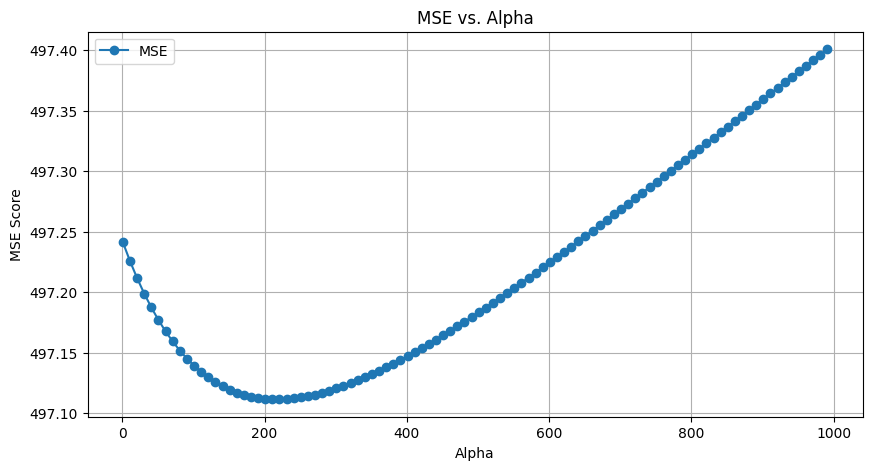

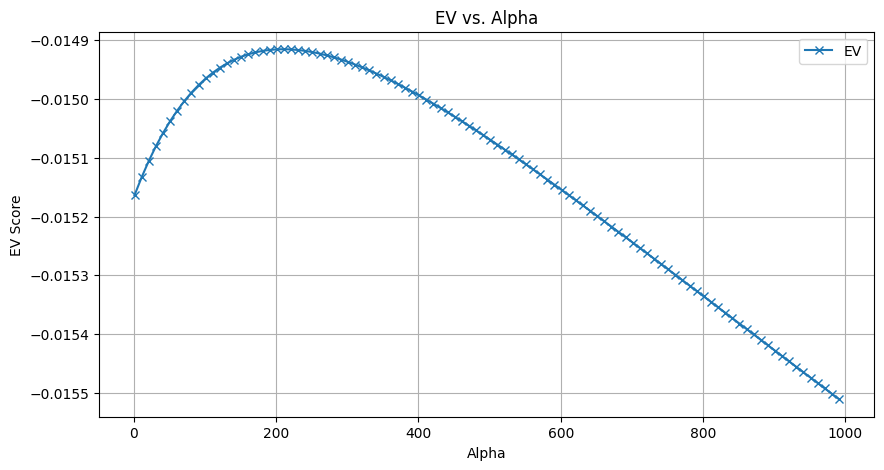

Best Alpha for MSE: 221
Best MSE Score: 497.11137945059545
MSE train Score: 484.98643175315135
Best Alpha for EV: 211
Best EV Score: -0.014915652127886214
EV train Score: 0.022503883701222673


In [8]:
import matplotlib.pyplot as plt
def plot_search_results(results):
    alphas = results['param_alpha'].data
    mse_scores = -results['mean_test_MSE']  # Convert to positive for plotting
    ev_scores = results['mean_test_EV']

    # Plot MSE scores
    plt.figure(figsize=(10, 5))
    plt.plot(alphas, mse_scores, label='MSE', marker='o')
    plt.xlabel('Alpha')
    plt.ylabel('MSE Score')
    plt.title('MSE vs. Alpha')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot EV scores
    plt.figure(figsize=(10, 5))
    plt.plot(alphas, ev_scores, label='EV', marker='x')
    plt.xlabel('Alpha')
    plt.ylabel('EV Score')
    plt.title('EV vs. Alpha')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print the best alpha and corresponding best MSE and EV scores
    best_alpha_mse = alphas[np.argmin(mse_scores)]
    best_mse = np.min(mse_scores)
    best_alpha_ev = alphas[np.argmax(ev_scores)]
    best_ev = np.max(ev_scores)
    train_mse = - results['mean_train_MSE'][np.argmin(mse_scores)]
    train_ev = results['mean_train_EV'][np.argmin(ev_scores)]


    print(f'Best Alpha for MSE: {best_alpha_mse}')
    print(f'Best MSE Score: {best_mse}')
    print(f'MSE train Score: {train_mse}')
    print(f'Best Alpha for EV: {best_alpha_ev}')
    print(f'Best EV Score: {best_ev}')
    print(f'EV train Score: {train_ev}')






#print(learner)
plot_search_results(learner.cv_results_)

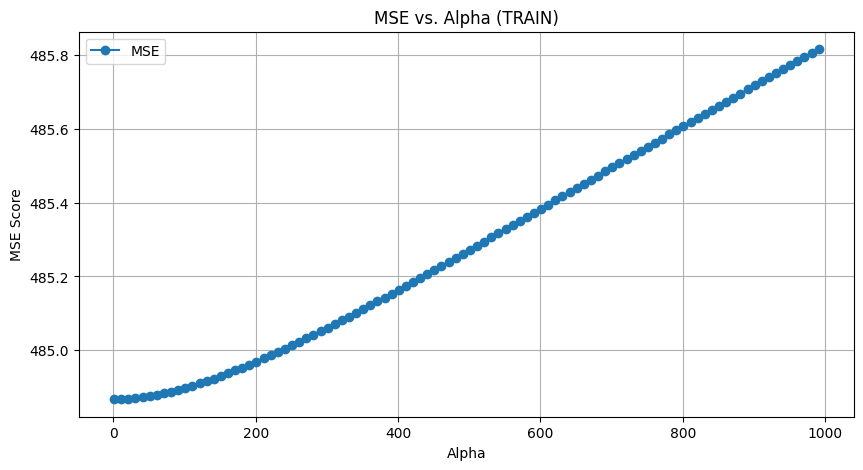

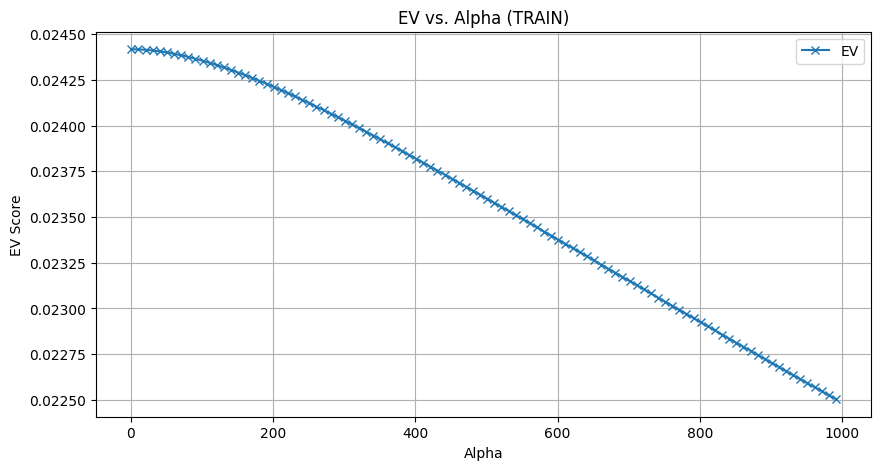

In [9]:
import matplotlib.pyplot as plt
def plot_search_results_train(results):
    alphas = results['param_alpha'].data
    mse_scores = -results['mean_train_MSE']  # Convert to positive for plotting
    ev_scores = results['mean_train_EV']

    # Plot MSE scores
    plt.figure(figsize=(10, 5))
    plt.plot(alphas, mse_scores, label='MSE', marker='o')
    plt.xlabel('Alpha')
    plt.ylabel('MSE Score')
    plt.title('MSE vs. Alpha (TRAIN)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot EV scores
    plt.figure(figsize=(10, 5))
    plt.plot(alphas, ev_scores, label='EV', marker='x')
    plt.xlabel('Alpha')
    plt.ylabel('EV Score')
    plt.title('EV vs. Alpha (TRAIN)')
    plt.grid(True)
    plt.legend()
    plt.show()




plot_search_results_train(learner.cv_results_)

Here, we can see that both losses have their best value (the minimum for the MSE and the maximum for EV) around 211.
To find the best value we run the hyperparameter tuning once again with $\alpha$ going from 200 to 220.

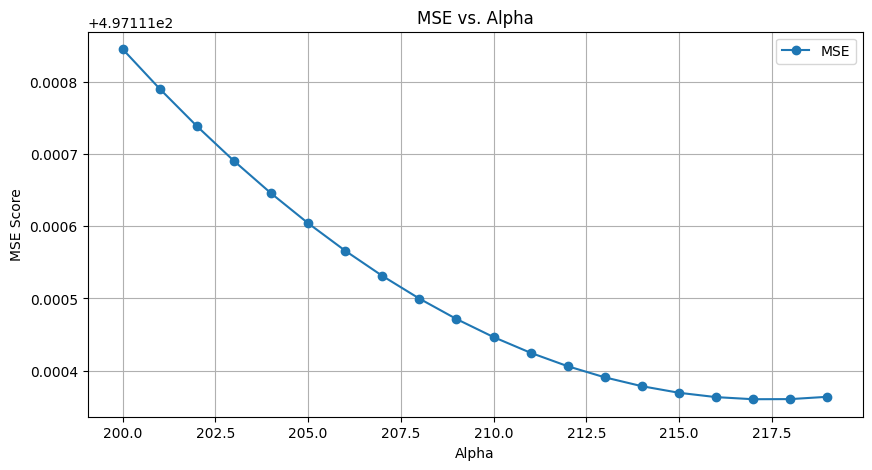

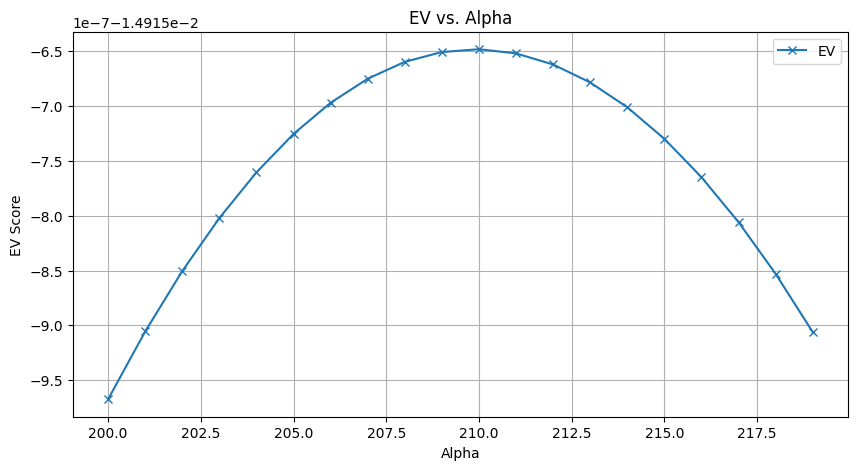

Best Alpha for MSE: 217
Best MSE Score: 497.11136065248473
MSE train Score: 484.98295455375063
Best Alpha for EV: 210
Best EV Score: -0.014915648329075593
EV train Score: 0.024212927822186647


In [10]:
k_grid = {'alpha': range(200,220)}
learner = GridSearchCV(estimator=RidgeRegression(), param_grid=k_grid,  return_train_score=True, scoring=scoring,cv=5,refit="MSE")
learner.fit(numFeatures, labels)
plot_search_results(learner.cv_results_)

We obtained that the best value for $\alpha$ to reduce the MSE is 217. It's 210 to maximize the EV.

In [11]:
learner.best_estimator_.coefficients

array([ 3.32046927e+01, -1.91542782e-06,  7.52517911e+00, -3.21791375e+00,
        1.29699046e-01, -1.02123176e+01, -1.20750019e+00, -7.78992372e+00,
        1.14590759e+00, -9.06062053e+00,  1.31259850e-02,  1.08813824e+00])

Here, we can see that coefficient are very similar except the second one wich is very low . This can be explained by the fact that it correspond to the duration of the song in millisecond which is the feature with the highest scale.

# Regression with numerical features normalized
Here, we ant to normalize all our features to avoid the situation where a feature is more important than others. To do so we use the z-score

In [12]:
df_zscore = (numFeaturesTable - numFeaturesTable.mean())/numFeaturesTable.std()
normalizedFeatures = df_zscore.values

df_zscore

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.024575,0.629241,-0.717145,0.300827,0.551845,-0.850198,-0.504106,0.758740,0.929302,-1.141858,0.221822
1,-0.730856,-0.845904,-1.889971,-1.784736,-0.078993,1.831724,-0.504092,-0.591208,-0.798686,-1.489711,0.221822
2,-0.160331,-0.742183,-1.122665,-0.293287,-0.273825,-0.315497,-0.504110,-0.507165,-1.365682,-1.528305,0.221822
3,-0.243213,-1.733297,-2.312984,-2.039243,-0.457307,1.774585,-0.503881,-0.428374,-1.276969,1.987850,-2.089671
4,-0.271918,0.295029,-0.788707,-0.282749,-0.303144,0.463397,-0.504110,-0.686282,-1.184398,-0.073348,0.221822
...,...,...,...,...,...,...,...,...,...,...,...
113995,1.462937,-2.274952,-1.615649,-1.617319,-0.401505,0.977647,2.493744,-0.668423,-1.697780,0.128332,2.533315
113996,1.462947,-2.263427,-2.084780,-2.000073,-0.421367,2.042236,2.648805,-0.570197,-1.693537,-1.231189,0.221822
113997,0.404825,0.358414,-1.241935,-0.524133,-0.403397,1.660308,-0.504110,-0.681030,1.037301,0.341253,0.221822
113998,0.520643,0.116398,-0.538239,-0.522940,-0.519728,0.198753,-0.504110,0.296501,-0.235547,0.460740,0.221822


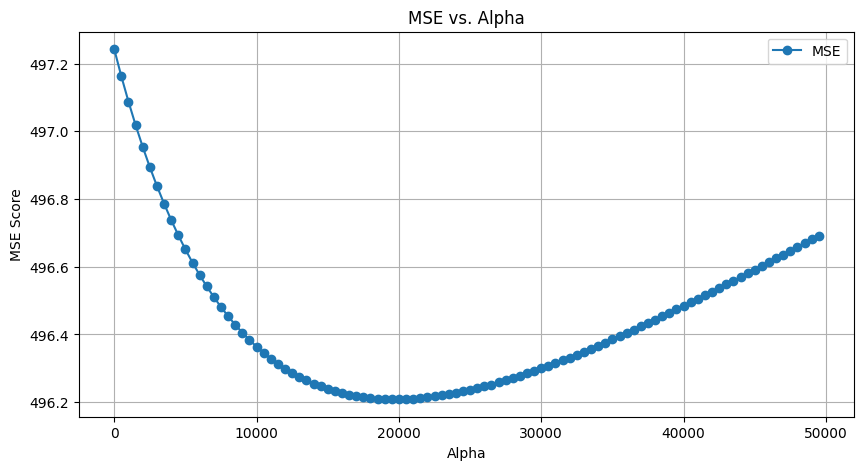

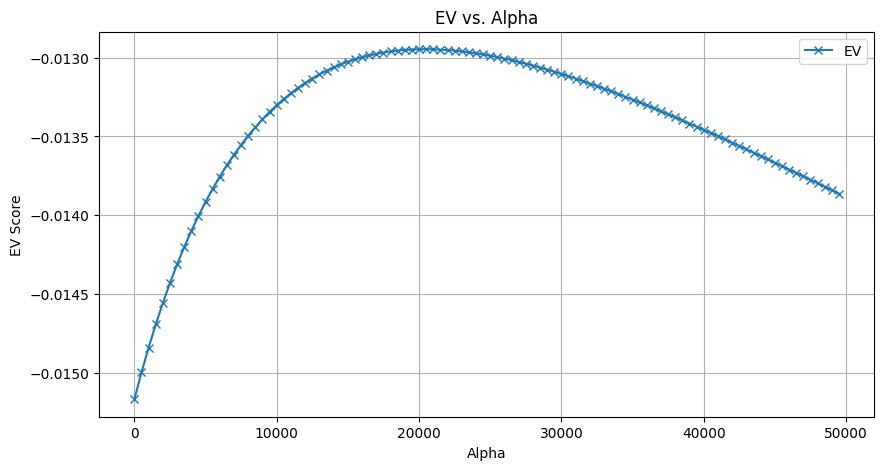

Best Alpha for MSE: 19501
Best MSE Score: 496.2085606617792
MSE train Score: 485.6972732794282
Best Alpha for EV: 20501
Best EV Score: -0.012946904688402493
EV train Score: 0.024417165043830468


In [13]:
k_grid = {'alpha': range(1,50000,500)}
learner = GridSearchCV(estimator=RidgeRegression(), param_grid=k_grid,  return_train_score=True, scoring=scoring,cv=5,refit="MSE")
learner.fit(normalizedFeatures, labels)
plot_search_results(learner.cv_results_)

Here we see that $\alpha$ is way bigger than before meaning that there is a high penalization on the coefficient. Nonetheless, we still have very similar results which means that the normalization of the data is not the reason why we have not a good result

In [14]:
learner.best_estimator_.coefficients

array([33.23853509, -0.16488917,  1.04973035, -0.57797119,  0.57346148,
       -1.04912283, -0.29338887, -2.0211518 ,  0.14967217, -1.85457529,
        0.29497095,  0.41828061])

We can also notice that the coefficent are not much different than before. Only the second coefficient change a lot beacause the normalization impacted a lot the duration feature.

# Ridge regression with numerical and categorical features

## Feature selection
First we have to get all the features and convert them such as the algorithm can use them. First we add the *mode* and *key* features which are already numbers. Then, we convert the *explicit* feature in integer by mapping 0 to False and 1 to True. Finally we use one hot encoder to convert the *track_genre* into as many features as there are genre.

In [15]:
features = dataset.drop(["track_id","album_name","track_name","popularity","artists"],axis = 1)
features["explicit"] = features["explicit"].astype(int)
features = pd.get_dummies(features)
features

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,...,0,0,0,0,0,0,0,0,0,0
1,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,...,0,0,0,0,0,0,0,0,0,0
2,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,...,0,0,0,0,0,0,0,0,0,0
4,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,...,0,0,0,0,0,0,0,0,0,1
113996,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,...,0,0,0,0,0,0,0,0,0,1
113997,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,...,0,0,0,0,0,0,0,0,0,1
113998,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,...,0,0,0,0,0,0,0,0,0,1


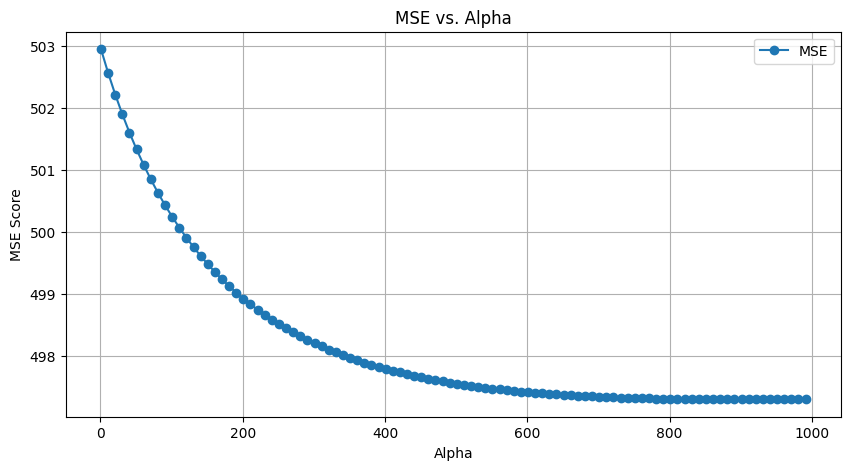

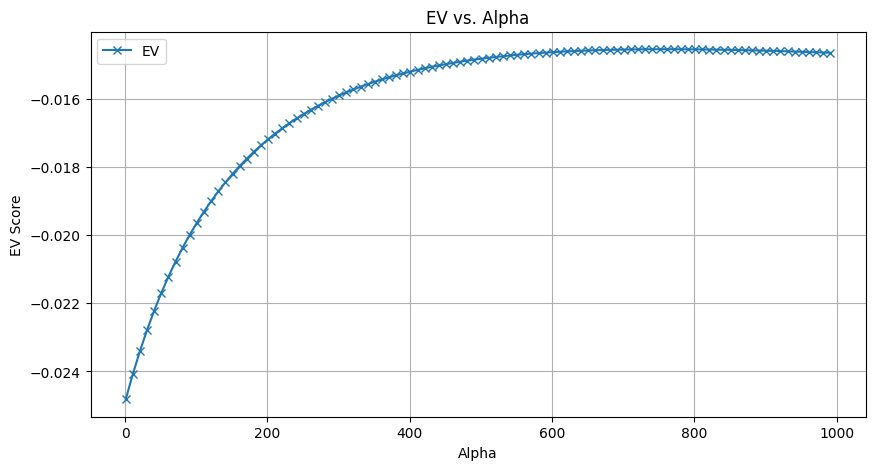

Best Alpha for MSE: 881
Best MSE Score: 497.3012352221397
MSE train Score: 394.506478828473
Best Alpha for EV: 761
Best EV Score: -0.014554928762797802
EV train Score: 0.26033113335683233


In [16]:
k_grid = {'alpha': range(1, 1000, 10)}
learner = GridSearchCV(estimator=RidgeRegression(), param_grid=k_grid,  return_train_score=True,scoring=scoring,refit="MSE")
learner.fit(features, labels)
plot_search_results(learner.cv_results_)